# **Building a Reflection Agent with External Knowledge Integration**


Estimated time needed: **30** minutes


In this lab, you will build a deep research agent that uses a technique called **Reflection**. This agent is designed to not just answer a question, but to critique its own answer, identify weaknesses, use tools to find more information, and then revise its answer to be more accurate and comprehensive. We will be building an agent that acts as a nutritional expert, capable of providing detailed, evidence-based advice.


## __Table of Contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-Required-Libraries">Installing Required Libraries</a></li>
            <li><a href="#Importing-Required-Libraries">Importing Required Libraries</a></li>
        </ol>
    </li>
    <li>
        <a href="#Writing-the-Code">Writing the Code</a>
        <ol>
            <li><a href="#Tavily-Search-API-Key-Setup">Tavily Search API Key Setup</a></li>
            <li><a href="#Tool-Setup:-Tavily-Search">Tool Setup: Tavily Search</a></li>
            <li><a href="#LLM-and-Prompting">LLM and Prompting</a></li>
            <li><a href="#Defining-the-Responder">Defining the Responder</a></li>
            <li><a href="#Tool-Execution">Tool Execution</a></li>
            <li><a href="#Defining-the-Revisor">Defining the Revisor</a></li>
        </ol>
    </li>
    <li><a href="#Building-the-Graph">Building the Graph</a></li>
    <li><a href="#Running-the-Agent">Running the Agent</a></li>
</ol>


## Objectives

After completing this lab, you will be able to:

 - Understand the core principles of the Reflexion framework.
 - Build an agent that can critique and improve its own responses.
 - Use LangGraph to create a cyclical, iterative agent workflow.
 - Integrate external tools, such as web search, into a LangChain agent.
 - Construct complex prompts for nuanced agent behavior.


----


## Setup


For this lab, we will be using the following libraries:

* [`langchain-openai`](https://python.langchain.com/docs/integrations/llms/openai/) for OpenAI integrations with LangChain.
* [`langchain`](https://www.langchain.com/) for core LangChain functionalities.
* [`openai`](https://pypi.org/project/openai/) for interacting with the OpenAI API.
* [`langchain-community`](https://pypi.org/project/langchain-community/) for community-contributed LangChain integrations.
* [`langgraph`](https://python.langchain.com/docs/langgraph) for defining structured workflows (such as Reflection loops).


### Installing Required Libraries
Run the following to install the required libraries (it might take a few minutes):


In [1]:
# %%capture
# %pip install langchain-openai==0.3.10
# %pip install langchain==0.3.21
# %pip install openai==1.68.2
# %pip install langchain-community==0.2.1
# %pip install  --upgrade langgraph
# %pip install langchain_community==0.3.24

### Importing Required Libraries



In [1]:
import os
import json
import getpass
from typing import List, Dict
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage, BaseMessage
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph, MessageGraph

# API Disclaimer
This lab uses LLMs provided by Watsonx.ai and OpenAI. This environment has been configured to allow LLM use without API keys so you can prompt them for **free (with limitations)**. With that in mind, if you wish to run this notebook **locally outside** of Skills Network's JupyterLab environment, you will have to configure your own API keys. Please note that using your own API keys means that you will incur personal charges.
### Running Locally
If you are running this lab locally, you will need to configure your own API keys. This lab uses `ChatOpenAI` and `ChatWatsonx` modules from `langchain`. The following shows both configuration with instructions. **Replace all instances** of both modules with the following completed modules throughout the lab.

<p style='color: red'><b>DO NOT run the following cell if you aren't running locally, it will cause errors.</b>


In [2]:
# IGNORE IF YOU ARE NOT RUNNING LOCALLY
# from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
load_dotenv()


llm = ChatOpenAI(
    model="openai/gpt-oss-120b",
    base_url="https://api.groq.com/openai/v1",
    api_key = os.getenv("GROQ_API_KEY"),
)

---


## Writing the Code


### Tavily Search API Key Setup

We'll use Tavily search as our external research tool. You can get an API key at https://app.tavily.com/sign-in   


**Disclaimer:** Signing up for Tavily provides you with free credits, more than enough for this project's needs. If you require additional credits for further use, please add them at your own discretion.

![image.png](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/UjJx1-0vss4_3lwsUF8n0w/image.png)

You need to copy the key from Tavily's API website and paste the key in the textbox that appears after running the next cell and hit enter to continue (see image).


In [3]:
def _set_if_undefined(var: str) -> None:
    if os.environ.get(var):
        return
    os.environ[var] = getpass.getpass(var)
_set_if_undefined("TAVILY_API_KEY")

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

### Tool Setup: Tavily Search

Our agent needs a tool to find information. We'll use the `TavilySearchResults` tool, which is a wrapper around the Tavily Search API. This allows our agent to perform web searches to gather evidence for its answers.

Let's test the tool to see how it works. We'll give it a sample query and print the results:


In [7]:
tavily_tool=TavilySearchResults(max_results=1)
sample_query = "healthy breakfast recipes"
search_results = tavily_tool.invoke(sample_query)
print(search_results)

/var/folders/nm/srw3ygl55jbgpddqwgysqjpm0000gn/T/ipykernel_17477/2046710301.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool=TavilySearchResults(max_results=1)


[{'title': '60 Healthy Breakfast Ideas Recipe', 'url': 'https://www.loveandlemons.com/healthy-breakfast-ideas/', 'content': 'Below, I share over 60 healthy breakfast recipes, divided into 11 (yes, 11!) categories: oats, eggs, smoothies, bowls, quick breads, pancakes & waffles, breakfast tacos, breakfast cookies, toast, muffins & scones, and bars & balls. Whether you’re someone who craves something savory or sweet first thing in the morning, or whether you like to enjoy breakfast at home or grab it and go, you’re sure to find some healthy breakfast ideas you love.\n\n#### Healthy Breakfast Oats [...] If you’re someone who wants to prioritize protein in your breakfast, egg recipes are a great choice. Make a quick omelet, scrambled eggs, or fried eggs in the morning, or try one of the recipes below to change things up. Make egg bites for a portable breakfast option, for example. On days when you have more time, start the day with a big breakfast casserole or shakshuka. [...] If you’re loo

### LLM and Prompting

At the core of our agent is a Large Language Model (LLM). We'll use OpenAI's GPT-4o-mini for this lab. First, let's see how the standalone LLM responds to a simple question without any special prompting or tools:


In [8]:
question="Any ideas for a healthy breakfast"
response=llm.invoke(question).content
print(response)

Here are a handful of tasty, balanced breakfast ideas you can mix‑and‑match to keep things fresh (and keep the nutrition profile in the “healthy” zone). Feel free to tweak portion sizes or ingredients to suit your tastes, dietary needs, and time constraints.

---

## 1️⃣ Overnight “Oat‑to‑Go” Jars  
**Why it’s healthy:**  
- **Complex carbs** from rolled oats give steady energy.  
- **Fiber & protein** from Greek yogurt or plant‑based yogurt keep you full.  
- **Healthy fats** from nuts/seeds help with satiety and brain function.  

**Basic recipe (serves 1):**  

| Ingredient | Amount | Nutrient focus |
|------------|--------|----------------|
| Rolled oats | ½ cup (40 g) | Complex carbs, fiber |
| Milk or fortified plant milk | ½ cup (120 ml) | Calcium, vitamin D |
| Greek yogurt (plain) | ¼ cup (60 g) | Protein, probiotics |
| Chia seeds | 1 Tbsp (12 g) | Omega‑3, extra fiber |
| Fresh berries (blueberries, strawberries) | ½ cup | Antioxidants, vitamin C |
| Optional sweetener | 1 t

#### Crafting the Agent's Persona and Logic

To guide the agent's behavior, we create a detailed prompt template. This template gives the LLM a specific persona, Dr. Paul Saladino, an advocate for animal-based nutrition, and a set of instructions to follow. This structured approach ensures the agent's responses are consistent and follow the reflection logic.

The prompt instructs the agent to:
1.  Provide an initial answer.
2.  Present the rationale behind its nutritional advice.
3.  Challenge conventional wisdom about plant-based foods.
4.  **Reflect and critique** its own answer.
5.  Generate **search queries** to find missing information.


In [4]:
prompt_template = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are Dr. Paul Saladino, "Carnivore MD," advocating for animal-based nutrition and challenging plant-centric dietary dogma. Focus on the superior bioavailability of animal foods and the potential toxicity of plant compounds such as oxalates, lectins, and phytates.

        Your response must follow these steps:
        1. {first_instruction}
        2. Present the evolutionary and biochemical rationale for animal-based nutrition, emphasizing nutrient density, bioavailability, and the absence of plant antinutrients.
        3. Challenge conventional "plants are healthy" narratives with mechanistic evidence about plant defense compounds and their impact on human physiology.
        4. Reflect and critique your answer. Be rigorous about evolutionary consistency and nutrient science.
        5. After the reflection, **list 1-3 search queries separately** for researching antinutrients, bioavailability studies, or evolutionary nutrition. Do not include them inside the reflection.

        Focus on: organ meats as superfoods, the carnivore elimination protocol, and why "fiber is unnecessary" based on human evolutionary biology.
        """
    ),
    MessagesPlaceholder(variable_name="messages"),
    (
        "system", 
        "Answer the user's question above using the required format, emphasizing the superiority of animal-based nutrition."
    ),
])

### Defining the Responder

The **Responder** is the first component of our agent's thinking process. It generates the initial draft of the answer based on the user's question and the persona we defined in the prompt.

Here, we create a chain that combines our prompt template with the LLM. We then invoke it with our sample question to see the initial, un-critiqued response:


In [5]:
first_responder_prompt = prompt_template.partial(first_instruction="Provide a detailed ~250 word answer")

# temp_chain = first_responder_prompt| llm
# response = temp_chain.invoke({"messages": [HumanMessage(content=question)]})
# print(response.content)

#### Structuring the Agent's Output: Data Models

To make the agent's self-critique process reliable, we need to enforce a specific output structure. We use Pydantic `BaseModel` to define two data classes:

1.  `Reflection`: This class structures the self-critique, requiring the agent to identify what information is `missing` and what is `superfluous` (unnecessary).
2.  `AnswerQuestion`: This class structures the entire response. It forces the agent to provide its main `answer`, a `reflection` (using the `Reflection` class), and a list of `search_queries`.


In [6]:
class Reflection(BaseModel):
	missing: str = Field(description="What information is missing")
	superfluous: str = Field(description="What information is unnecessary")

class AnswerQuestion(BaseModel):
	answer: str = Field(description="Main response to the question")
	reflection: Reflection = Field(description="Self-critique of the answer")
	search_queries: List[str] = Field(description="Queries for additional research")

#### Binding Tools to the Responder

Now, we bind the `AnswerQuestion` data model as a **tool** to our LLM chain. This crucial step forces the LLM to generate its output in the exact JSON format defined by our Pydantic classes. The LLM doesn't just write text; it calls this "tool" to structure its entire thought process.

After invoking this new chain, we can see the structured output, including the initial answer, the self-critique, and the generated search queries:


In [7]:
initial_chain = first_responder_prompt| llm.bind_tools(tools=[AnswerQuestion])
# response=initial_chain.invoke({"messages":[HumanMessage(question)]})
# print("---Full Structured Output---")
# print(response.tool_calls)

In [ ]:
answer_content = response.tool_calls[0]['args']['answer']
print("---Initial Answer---")
print(answer_content)

---Initial Answer---
A carnivore‑focused breakfast that leans into the evolutionary and biochemical strengths of animal foods would look something like this:

**Meal**: 4‑oz grass‑fed beef liver sautéed in 1 tbsp tallow, paired with 2 large pasture‑raised eggs cooked sunny‑side‑up, and a side of 2‑3 oz smoked wild‑caught salmon. Finish with a cup of bone‑broth (home‑made from beef knuckles) seasoned with a pinch of sea‑salt.

**Why it works**:
1. **Nutrient density & bioavailability** – Liver supplies vitamin A, B12, folate, iron, copper, and zinc in forms that are 2‑5 times more bioavailable than plant sources. Eggs deliver choline, DHA, and high‑quality protein with a perfect 9:1 biological value. Salmon adds omega‑3 EPA/DHA, selenium, and the unique protein‑bound vitamin D3. All are absorbed efficiently because animal matrices lack phytates and oxalates that chelate minerals.
2. **Evolutionary match** – Our ancestors spent >90 % of their caloric intake on animal tissue, especially o

In [18]:
Reflection_content = response.tool_calls[0]['args']['reflection']
print("---Reflection Answer---")
print(Reflection_content)

---Reflection Answer---
{'missing': 'The answer could have included a brief note on electrolytes (magnesium, potassium) and hydration, which are often emphasized in carnivore protocols. It also lacks citation of specific studies on bioavailability differences between animal and plant sources.', 'superfluous': 'The detailed evolutionary timeline could be trimmed slightly; the core message is already clear without extensive background on colon length.'}


In [19]:
search_queries = response.tool_calls[0]['args']['search_queries']
print("---Search Queries---")
print(search_queries)

---Search Queries---
['human evolution animal based diet nutrient bioavailability studies', 'impact of phytates oxalates lectins on mineral absorption in humans', 'clinical outcomes of carnivore elimination protocol organ meats']


### Tool Execution

Now that the Responder has generated search queries based on its self-critique, the next step is to actually *execute* those searches. We'll define a function, `execute_tools`, that takes the agent's state, extracts the search queries, runs them through the Tavily tool, and returns the results.

We will also manage the conversation history in `response_list`:


In [20]:
response_list=[]
response_list.append(HumanMessage(content=question))
response_list.append(response)

In [21]:
tool_call=response.tool_calls[0]
search_queries = tool_call["args"].get("search_queries", [])
print(search_queries)

['human evolution animal based diet nutrient bioavailability studies', 'impact of phytates oxalates lectins on mineral absorption in humans', 'clinical outcomes of carnivore elimination protocol organ meats']


In [8]:
tavily_tool=TavilySearchResults(max_results=3)


def execute_tools(state: List[BaseMessage]) -> List[BaseMessage]:
    print("Executing tools...")
    print(state)
    print("----")
    last_ai_message = state[-1]
    tool_messages = []
    for tool_call in last_ai_message.tool_calls:
        if tool_call["name"] in ["AnswerQuestion", "ReviseAnswer"]:
            call_id = tool_call["id"]
            search_queries = tool_call["args"].get("search_queries", [])
            query_results = {}
            for query in search_queries:
                result = tavily_tool.invoke(query)
                query_results[query] = result
            tool_messages.append(ToolMessage(
                content=json.dumps(query_results),
                tool_call_id=call_id)
            )
    return tool_messages

/var/folders/nm/srw3ygl55jbgpddqwgysqjpm0000gn/T/ipykernel_18760/247949423.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool=TavilySearchResults(max_results=3)


In [23]:
tool_response = execute_tools(response_list)
# Use .extend() to add all tool messages from the list
response_list.extend(tool_response)

In [24]:
tool_response

[ToolMessage(content='{"human evolution animal based diet nutrient bioavailability studies": [{"title": "Evolutionary Adaptations to Dietary Changes - PMC - PubMed Central", "url": "https://pmc.ncbi.nlm.nih.gov/articles/PMC4163920/", "content": "Additional evidence for adaptations in OR genes was provided by genome-wide scans for signals of selection based on signals of complete selective sweeps in human populations (169), on the ratio of nonsynonymous to synonymous substitutions in humans compared to chimpanzee (27, 112), and on EHH in genes involved in olfaction (162). In addition to taste and olfactory receptor genes, the broader category of genes involved in chemosensory perception was also reported to be enriched for signals of selection based on the EHH approach (162), nonsynonymous to synonymous substitutions ratio in the comparison between human and chimpanzee species (27, 111), and population differentiation (F ST) (10).", "score": 0.97801}, {"title": "Animal Source Foods and 

In [25]:
response_list

[HumanMessage(content='Any ideas for a healthy breakfast', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'fc_c09c42db-da48-4e51-a2c0-756763e722de', 'function': {'arguments': '{"answer":"A carnivore‑focused breakfast that leans into the evolutionary and biochemical strengths of animal foods would look something like this:\\n\\n**Meal**: 4‑oz grass‑fed beef liver sautéed in 1\u202ftbsp tallow, paired with 2\u202flarge pasture‑raised eggs cooked sunny‑side‑up, and a side of 2‑3\u202foz smoked wild‑caught salmon. Finish with a cup of bone‑broth (home‑made from beef knuckles) seasoned with a pinch of sea‑salt.\\n\\n**Why it works**:\\n1. **Nutrient density \\u0026 bioavailability** – Liver supplies vitamin\u202fA, B12, folate, iron, copper, and zinc in forms that are 2‑5\u202ftimes more bioavailable than plant sources. Eggs deliver choline, DHA, and high‑quality protein with a perfect 9:1 biological value. Salmon adds omega‑3 EP

### Defining the Revisor

The **Revisor** is the final piece of the Reflection loop. Its job is to take the original answer, the self-critique, and the new information from the tool search, and then generate an improved, more evidence-based response.

We create a new set of instructions (`revise_instructions`) that guide the Revisor. These instructions emphasize:
- Incorporating the critique.
- Adding numerical citations from the research.
- Distinguishing between correlation and causation.
- Adding a "References" section.


In [9]:
revise_instructions = """Revise your previous answer using the new information, applying the rigor and evidence-based approach of Dr. David Attia.
- Incorporate the previous critique to add clinically relevant information, focusing on mechanistic understanding and individual variability.
- You MUST include numerical citations referencing peer-reviewed research, randomized controlled trials, or meta-analyses to ensure medical accuracy.
- Distinguish between correlation and causation, and acknowledge limitations in current research.
- Address potential biomarker considerations (lipid panels, inflammatory markers, and so on) when relevant.
- Add a "References" section to the bottom of your answer (which does not count towards the word limit) in the form of:
- [1] https://example.com
- [2] https://example.com
- Use the previous critique to remove speculation and ensure claims are supported by high-quality evidence. Keep response under 250 words with precision over volume.
- When discussing nutritional interventions, consider metabolic flexibility, insulin sensitivity, and individual response variability.
"""
revisor_prompt = prompt_template.partial(first_instruction=revise_instructions)

#### Structuring the Revisor's Output

Just as we did with the Responder, we define a Pydantic class, `ReviseAnswer`, to structure the Revisor's output. This class inherits from `AnswerQuestion` but adds a new field for `references`, ensuring the agent includes citations in its revised answer.

We then bind this new tool to the revisor chain:


In [10]:
qwen_llm = ChatOpenAI(
    model="qwen/qwen3-32b",  # or another model of your choice
    base_url="https://api.groq.com/openai/v1",
    api_key = os.getenv("GROQ_API_KEY"),
)

In [11]:
class ReviseAnswer(AnswerQuestion):
    """Revise your original answer to your question."""
    references: List[str] = Field(description="Citations motivating your updated answer.")
revisor_chain = revisor_prompt | qwen_llm.bind_tools(tools=[ReviseAnswer])

#### Invoking the Revisor

Finally, we invoke the `revisor_chain`, passing it the entire conversation history: the original question, the first response (with its critique and search queries), and the new information gathered from the tool search. This provides the Revisor with all the context it needs to generate a final, improved answer.


In [38]:
response = revisor_chain.invoke({"messages": response_list})
print("---Revised Answer with References---")
print(response)
print(response.tool_calls[0]['args'])

---Revised Answer with References---
content='' additional_kwargs={'tool_calls': [{'id': 'y50vh18gt', 'function': {'arguments': '{"answer":"A carnivore breakfast optimized for bioavailability and evolutionary alignment might include:\\n\\n**Meal**: 100g grass-fed liver (for retinol, B12, iron), 100g pasture-raised egg yolk (for choline, omega-3s), 75g wild-caught salmon (for EPA/DHA), and 200ml bone broth (for collagen, glycine). Optional: add cultured tallow for electrolytes (sodium/potassium) to address carnivore-specific needs [3].\\n\\n**Scientific rationale**:\\n1. **Bioavailability superiority**: Animal proteins provide complete amino acid profiles (biological value scores \\u003e90%) and nutrient forms like preformed retinol (vs. beta-carotene in plants) with absorption rates 4x higher [2]. Phytates in plants bind iron/zinc, reducing absorption by 50-90% (vs. negligible impact in animal matrices) [4].\\n2. **Evolutionary consistency**: Hominin diets historically included organ m

In [39]:
from pprint import pprint
pprint(response.tool_calls[0]['args'])

{'answer': 'A carnivore breakfast optimized for bioavailability and '
           'evolutionary alignment might include:\n'
           '\n'
           '**Meal**: 100g grass-fed liver (for retinol, B12, iron), 100g '
           'pasture-raised egg yolk (for choline, omega-3s), 75g wild-caught '
           'salmon (for EPA/DHA), and 200ml bone broth (for collagen, '
           'glycine). Optional: add cultured tallow for electrolytes '
           '(sodium/potassium) to address carnivore-specific needs [3].\n'
           '\n'
           '**Scientific rationale**:\n'
           '1. **Bioavailability superiority**: Animal proteins provide '
           'complete amino acid profiles (biological value scores >90%) and '
           'nutrient forms like preformed retinol (vs. beta-carotene in '
           'plants) with absorption rates 4x higher [2]. Phytates in plants '
           'bind iron/zinc, reducing absorption by 50-90% (vs. negligible '
           'impact in animal matrices) [4].\n'
    

In [40]:
response_list.append(response)

## Building the Graph

Now we will use **LangGraph** to assemble these components—Responder, Tool Executor, and Revisor—into a cohesive, cyclical workflow. A graph is a natural way to represent this process, where nodes represent the different stages of thinking and edges represent the flow of information between them.

### Defining the Event Loop

The core of our graph is the event loop. This function determines whether the agent should continue its revision process or if it has reached a satisfactory conclusion. We'll set a maximum number of iterations to prevent the agent from getting stuck in an infinite loop:


In [12]:
MAX_ITERATIONS = 4

In [13]:
def event_loop(state: List[BaseMessage]) -> str:
    count_tool_visits = sum(isinstance(item, ToolMessage) for item in state)
    num_iterations = count_tool_visits
    if num_iterations >= MAX_ITERATIONS:
        return END
    return "execute_tools"

In [14]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages

# class AgentState(TypedDict):
#     messages : Annotated[List, add_messages]

In [15]:
graph = MessageGraph()

graph.add_node("respond", initial_chain)
graph.add_node("execute_tools", execute_tools)
graph.add_node("revisor", revisor_chain)

/var/folders/nm/srw3ygl55jbgpddqwgysqjpm0000gn/T/ipykernel_18760/2614510750.py:1: LangGraphDeprecatedSinceV10: MessageGraph is deprecated in LangGraph v1.0.0, to be removed in v2.0.0. Please use StateGraph with a `messages` key instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  graph = MessageGraph()


In [16]:
graph.add_edge("respond", "execute_tools")
graph.add_edge("execute_tools", "revisor")

In [17]:
graph.add_conditional_edges("revisor", event_loop)
graph.set_entry_point("respond")

In [18]:
app = graph.compile()

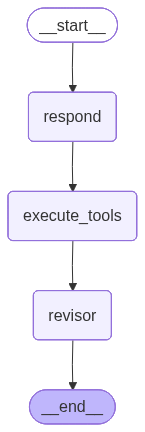

In [19]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

## Running the Agent

With our graph compiled, we're ready to run the full Reflection agent. We'll give it a new, more complex query that requires careful, evidence-based advice.

As the agent runs, we can see the entire process unfold: the initial draft, the self-critique, the tool searches, and the final, revised answer that incorporates the new evidence.


In [20]:
responses = app.invoke(
    """I'm pre-diabetic and need to lower my blood sugar, and I have heart issues.
    What breakfast foods should I eat and avoid"""
)

Executing tools...
[HumanMessage(content="I'm pre-diabetic and need to lower my blood sugar, and I have heart issues.\n    What breakfast foods should I eat and avoid", additional_kwargs={}, response_metadata={}, id='880b1dbf-5ffe-4cc0-a874-b18457693666'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'fc_f6cb6812-8f4a-4598-9628-7f0709d2ec91', 'function': {'arguments': '{"answer":"For a carnivore‑style breakfast that supports glucose control and cardiovascular health, prioritize nutrient‑dense animal foods that are low in carbohydrate and free of plant antinutrients.  \\n\\n**Eat**:  \\n- **Eggs** (preferably pastured, cooked any style) – provide high‑quality protein, choline, and vitamin\u202fD, with a glycemic index of zero.  \\n- **Beef liver** (30‑50\u202fg) – an unrivaled source of iron, copper, vitamin\u202fA, B‑complex (especially B12 and riboflavin), and selenium, all highly bioavailable and without phytates that hinder absorption.  \\n- **Fatty fish** (sardine

APIStatusError: Error code: 413 - {'error': {'message': 'Request too large for model `qwen/qwen3-32b` in organization `org_01k42z7t32ekc8sg4fp8ph78ns` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Requested 9439, please reduce your message size and try again. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

In [ ]:
print("--- Initial Draft Answer ---")
initial_answer = responses[1].tool_calls[0]['args']['answer']
print(initial_answer)
print("\n")

print("--- Intermediate and Final Revised Answers ---")
answers = []

# Loop through all messages in reverse to find all tool_calls with answers
for msg in reversed(responses):
    if getattr(msg, 'tool_calls', None):
        for tool_call in msg.tool_calls:
            answer = tool_call.get('args', {}).get('answer')
            if answer:
                answers.append(answer)

# Print all collected answers
for i, ans in enumerate(answers):
    label = "Final Revised Answer" if i == 0 else f"Intermediate Step {len(answers) - i}"
    print(f"{label}:\n{ans}\n")
